In [92]:
import pandas as pd
import torch
from gensim import models
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
pip install --upgrade gensim

In [4]:


file_path = '/content/simpsons_script_lines.csv'

try:
    df = pd.read_csv(file_path, on_bad_lines='skip')
    print("File read successfully.")
except Exception as e:
    print("Error reading file:", e)


File read successfully.


<ipython-input-4-5f799f65036d>:4: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, on_bad_lines='skip')


In [5]:
df

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158243,9544,32,204,Miss Hoover: (OFF LISA'S REACTION) I'm back.,831000,true,464,3.0,Miss Hoover,Springfield Elementary School,I'm back.,im back,2.0
158244,9545,32,205,"Miss Hoover: You see, class, my Lyme disease t...",839000,true,464,3.0,Miss Hoover,Springfield Elementary School,"You see, class, my Lyme disease turned out to ...",you see class my lyme disease turned out to be,10.0
158245,9546,32,206,Miss Hoover: Psy-cho-so-ma-tic.,842000,true,464,3.0,Miss Hoover,Springfield Elementary School,Psy-cho-so-ma-tic.,psy-cho-so-ma-tic,1.0
158246,9547,32,207,Ralph Wiggum: Does that mean you were crazy?,844000,true,119,3.0,Ralph Wiggum,Springfield Elementary School,Does that mean you were crazy?,does that mean you were crazy,6.0


In [24]:
# убираем цифры (если они есть) из текста
def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    return text


In [25]:
df['normalized_text'] = df['normalized_text'].apply(remove_numbers)

In [26]:
text = df['normalized_text'].tolist()
text[:10]

['no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it',
 'wheres mr bergstrom',
 'i dont know although id sure like to talk to him he didnt touch my lesson plan what did he teach you',
 'that life is worth living',
 'the polls will be open from now until the end of recess now just in case any of you have decided to put any thought into this well have our final statements martin',
 'i dont think theres anything left to say',
 'bart',
 'victory party under the slide',
 nan,
 'mr bergstrom mr bergstrom']

In [28]:
df.dropna(subset=['normalized_text'], inplace=True)  # Удаление строк с NaN
df['normalized_text'] = df['normalized_text'].astype(str)  # Преобразование всех данных в строки


In [39]:
sentences = [text.split() for text in df['normalized_text']] #разбиваем на слова


In [42]:
# обучаем word2vec
model = models.Word2Vec()
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

(4774968, 6525090)

In [45]:

top_words = model.wv.index_to_key[:1000]

In [47]:
top_words[:10]

['the', 'you', 'i', 'a', 'to', 'and', 'of', 'it', 'that', 'my']

In [49]:
top_words.sort(key=lambda x: x[0], reverse=True)


In [50]:
top_words[:10]

['you',
 'your',
 'youre',
 'yeah',
 'yes',
 'youve',
 'youll',
 'ya',
 'years',
 'young']

In [56]:
# Получение соответствующих вложений
embeddings = np.array([model.wv[word] for word in top_words])

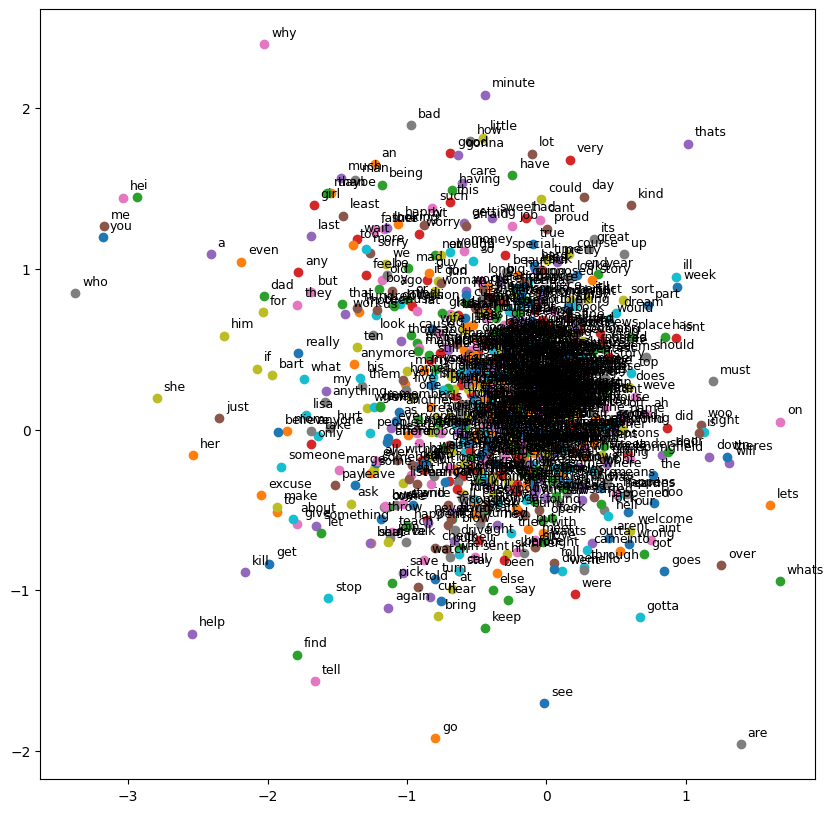

In [59]:
# топ 1000 слов

plt.figure(figsize=(10, 10))
for i, word in enumerate(top_words):
    plt.scatter(embeddings[i, 0], embeddings[i, 1])
    plt.text(embeddings[i, 0]+0.05, embeddings[i, 1]+0.05, word, fontsize=9)
plt.show()

In [62]:
w1 = 'homer'
w2 = 'marge'
w3 = 'bart'
w4 = 'school'
w5 = 'home'
w6 = 'lisa'


In [66]:
similar_words1 = model.wv.most_similar(positive=[w1, w3], negative=[w2], topn=1)
similar_words2 = model.wv.most_similar(positive=[w3, w4], negative=[w6], topn=1)
similar_words3 = model.wv.most_similar(positive=[w2, w5], negative=[w1], topn=1)
print(similar_words1)
print(similar_words2)
print(similar_words3)

[('lisa', 0.7512289881706238)]
[('church', 0.6979378461837769)]
[('back', 0.7132219672203064)]


# Попробуем сделать классификатор на основе реплик Барта и Лизы

In [69]:
names = ['Lisa Simpson', 'Bart Simpson']

In [70]:
data = df[df['raw_character_text'].isin(names)]
data

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
7,9556,32,216,Bart Simpson: Victory party under the slide!,882000,True,8.0,3.0,Bart Simpson,Springfield Elementary School,Victory party under the slide!,victory party under the slide,5.0
9,9558,32,218,Lisa Simpson: (CALLING) Mr. Bergstrom! Mr. Ber...,889000,True,9.0,374.0,Lisa Simpson,Apartment Building,Mr. Bergstrom! Mr. Bergstrom!,mr bergstrom mr bergstrom,4.0
11,9560,32,220,Lisa Simpson: Do you know where I could find him?,898000,True,9.0,374.0,Lisa Simpson,Apartment Building,Do you know where I could find him?,do you know where i could find him,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158233,9534,32,194,Lisa Simpson: Can we have wine?,808000,true,9,373.0,Lisa Simpson,SIMPSON HOUSE - BASEMENT STAIRCASE,Can we have wine?,can we have wine,4.0
158235,9536,32,196,Lisa Simpson: Can I have wine?,808000,true,9,373.0,Lisa Simpson,SIMPSON HOUSE - BASEMENT STAIRCASE,Can I have wine?,can i have wine,4.0
158237,9538,32,198,Lisa Simpson: Does Bart have to be there?,811000,true,9,373.0,Lisa Simpson,SIMPSON HOUSE - BASEMENT STAIRCASE,Does Bart have to be there?,does bart have to be there,6.0
158239,9540,32,200,Lisa Simpson: Can we do it this week?,812000,true,9,373.0,Lisa Simpson,SIMPSON HOUSE - BASEMENT STAIRCASE,Can we do it this week?,can we do it this week,6.0


In [72]:
data.dropna(subset=['normalized_text'], inplace=True)  # Удаление строк с NaN
data['normalized_text'] = data['normalized_text'].astype(str)  # Преобразование всех данных в строки

<ipython-input-72-51af9199ff9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['normalized_text'], inplace=True)  # Удаление строк с NaN
<ipython-input-72-51af9199ff9f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['normalized_text'] = data['normalized_text'].astype(str)  # Преобразование всех данных в строки


Переведем целевые переменные в числа через labelencoder

In [75]:
le = LabelEncoder()

In [76]:
le.fit(data['raw_character_text'])
le.transform(['Lisa Simpson','Bart Simpson'])

array([1, 0])

In [77]:
y=pd.Series(data=le.transform(data['raw_character_text']))
y.head()

0    1
1    1
2    0
3    1
4    1
dtype: int64

In [78]:
x_train, x_test = train_test_split(data['normalized_text'], test_size=0.2, random_state=23)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=23)

In [89]:
train_sentences = [text.split() for text in x_train]
model_2 = Word2Vec(sentences=train_sentences)


In [90]:
def sentence_to_vec(sentence, model):
    words = sentence.split()
    word_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(word_vecs) > 0: #усреднение векторов всех слов в предложении
        return np.mean(word_vecs, axis=0)#дает один вектор, представляющий всё предложение
    else:
        return np.zeros(model.vector_size)#вектор из нулей длиной, равной размеру векторов в модели (если слова нет в модели)

In [91]:
# Преобразование тренировочных и тестовых данных в векторы
X_train_vec = [sentence_to_vec(sentence, model) for sentence in x_train]
X_test_vec = [sentence_to_vec(sentence, model) for sentence in x_test]

Возьмем классификатор на основе случайного леса

In [123]:
classifier = RandomForestClassifier(n_estimators=500, max_depth=10, class_weight='balanced')
classifier.fit(X_train_vec, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500)

In [124]:
# делаем предсказание
predictions = classifier.predict(X_test_vec)

In [125]:
# Вывод отчета о классификации
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.84      0.67      2630
           1       0.47      0.17      0.25      2125

    accuracy                           0.54      4755
   macro avg       0.51      0.51      0.46      4755
weighted avg       0.52      0.54      0.49      4755



Как мы видим, классификатор плохо определил реплики Лизы, да и в целом результаты посредственные